In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter


In [209]:
def generate_time_series(file_name, n_steps):
    df = pd.read_csv(file_name)
    temp = df[["MaxTemp"]].to_numpy()
    series = np.array([temp[i:i + n_steps] for i in range(10000)], dtype=np.float32)
    return series

In [210]:
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label='$t$', y_label='$x$'):
    r, c = 3, 5
    fig, axes = plt.subplots(nrows=r, ncols=c, sharex=True, sharey=True, figsize=(20, 10))
    for row in range(r):
        for col in range(c):
            # sca`代表“Set Current Axes”，也就是设置当前的Axes对象
            plt.sca(axes[row][col])
            ix = col + row * c
            # print(series[ix, :])
            plt.plot(series[ix, :], ".-")
            if y is not None:
                # markersize 标记x的大小
                plt.plot(range(len(series[ix, :]), len(series[ix, :]) + len(y[ix])), y[ix], "yx", markersize=10)
            if y_pred is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :]) + len(y_pred[ix])), y_pred[ix], "rx")
            if y_pred_std is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :]) + len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
                plt.plot(range(len(series[ix, :]), len(series[ix, :]) + len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
            plt.grid(True)
            # plt.hlines(0, 0, 100, colors='red', linewidth=1)
            # plt.axis([0, len(series[ix, :]) + len(y[ix]), -1, 1])
            if x_label and row == r - 1:
                plt.xlabel(x_label, fontsize=16)
            if y_label and col == 0:
                plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.show()

C:\Users\王万能\AppData\Local\Temp\ipykernel_23388\1370572918.py:2: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


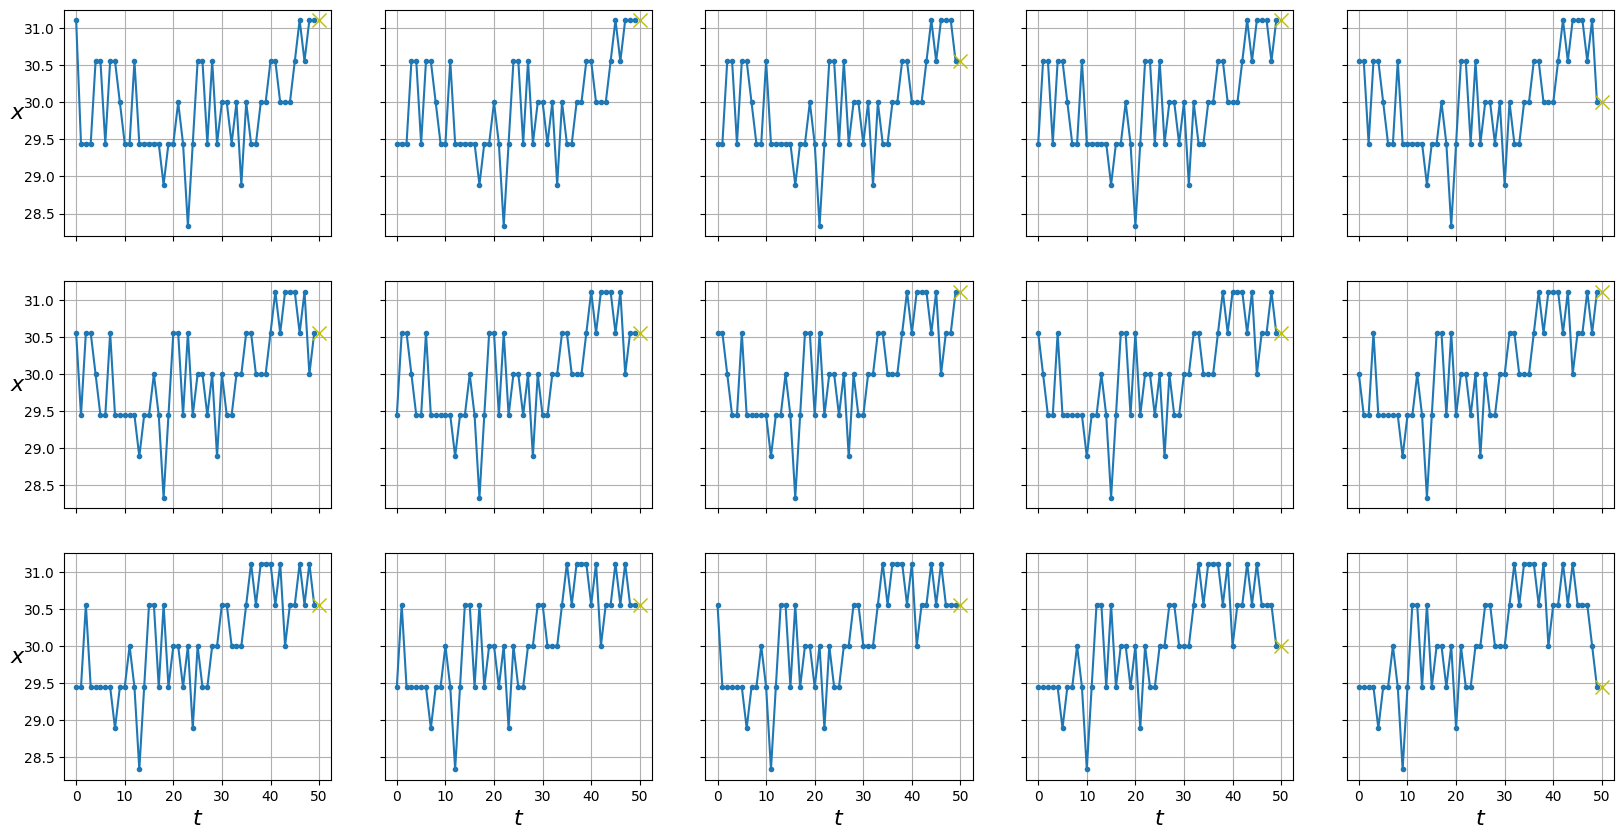

In [211]:
n_steps = 50
series = generate_time_series('Summary of Weather.csv', n_steps=n_steps)
x_train, y_train = series[:7000, :n_steps], series[:7000, -1]
x_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
x_test, y_test = series[9000:, :n_steps], series[9000:, -1]
plot_series(x_test, y_test)

In [212]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y=None, train=True):
        self.x = x
        self.y = y
        self.train = train

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if self.train:
            return torch.from_numpy(self.x[idx]), torch.from_numpy(self.y[idx])
        return torch.from_numpy(self.x[idx])


dataset = {
    'train': TimeSeriesDataset(x_train, y_train),
    'eval': TimeSeriesDataset(x_valid, y_valid),
    'test': TimeSeriesDataset(x_test, y_test, train=False)
}
dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [213]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.rnn = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, h = self.rnn(x)
        y = self.linear(x[:, -1, :])
        return y


rnn = RNN(input_size=1, hidden_size=20, output_size=1)

In [214]:
writer = SummaryWriter()

In [215]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs + 1))
    for epoch in bar:
        model.train()
        train_loss = []
        for i,batch in enumerate(dataloader['train']):
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            writer.add_scalar("loss" , loss.item(),
                              global_step=epoch * len(dataloader) + i)
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                x, y = batch
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                loss = criterion(y_pred, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss: {np.mean(train_loss):.5f} eval_loss: {np.mean(eval_loss):.5f}")

def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        predictions = torch.tensor([]).to(device)
        for batch in dataloader:
            x = batch
            x = x.to(device)
            pred = model(x)
            predictions = torch.cat([predictions, pred])
        return predictions
fit(rnn, dataloader, epochs=100)


loss: 0.00388 eval_loss: 0.00322: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s]   


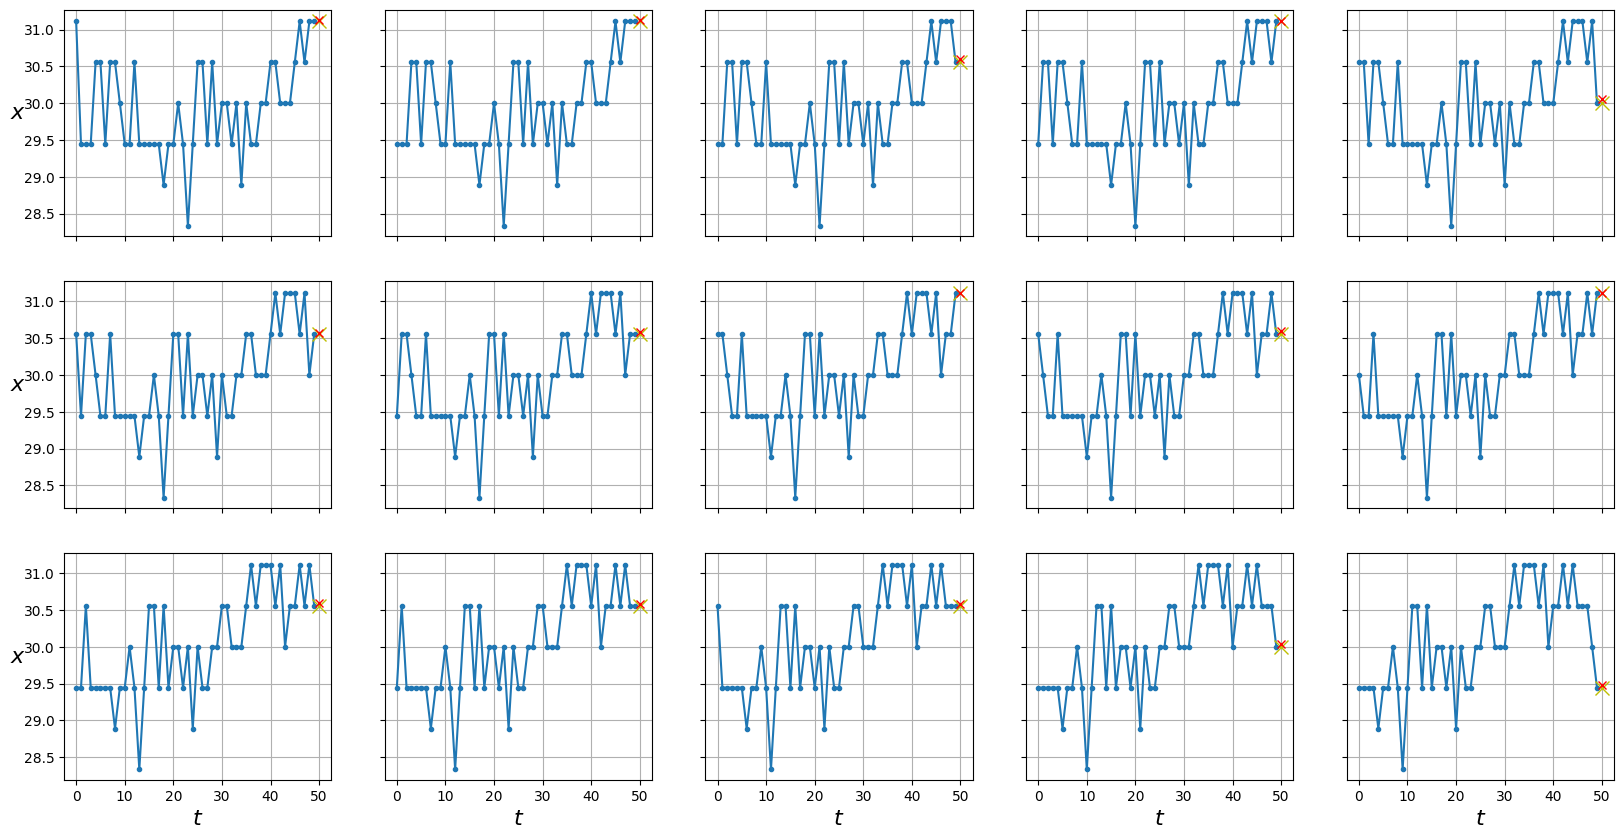

0.0017074410570785403

In [216]:
y_pred = predict(rnn, dataloader['test'])
plot_series(x_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

C:\Users\王万能\AppData\Local\Temp\ipykernel_23388\1370572918.py:2: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


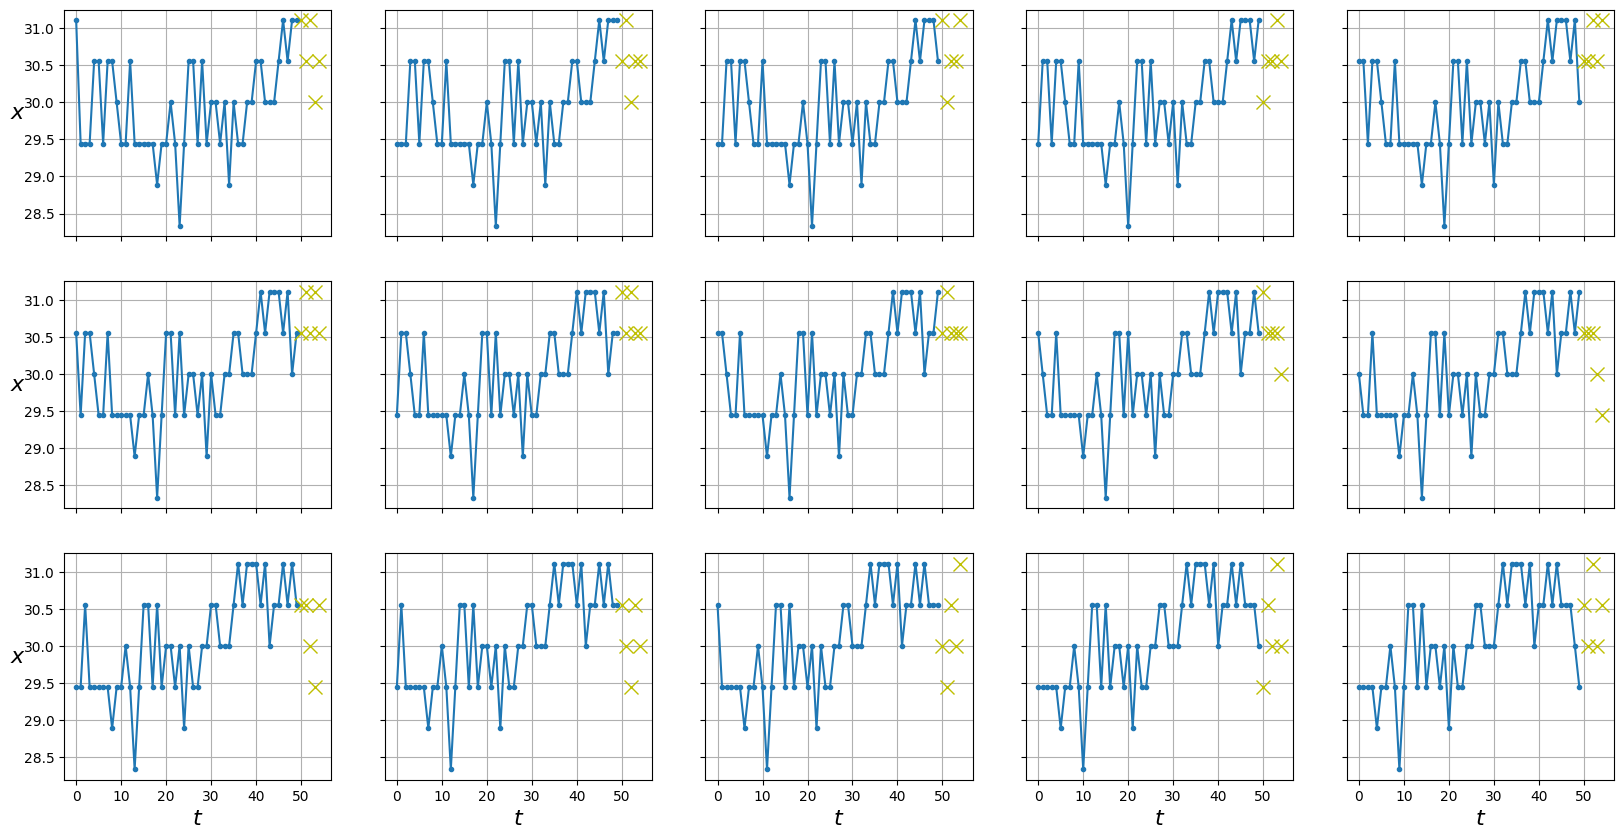

In [217]:
n_steps = 50
series = generate_time_series('Summary of Weather.csv', n_steps=n_steps + 5)
x_train, y_train = series[:7000, :n_steps], series[:7000, -5:, 0]
x_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -5:, 0]
x_test, y_test = series[9000:, :n_steps], series[9000:, -5:, 0]
plot_series(x_test, y_test)

dataset = {
    'train': TimeSeriesDataset(x_train, y_train),
    'eval': TimeSeriesDataset(x_valid, y_valid),
    'test': TimeSeriesDataset(x_test, y_test, train=False)
}
dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [218]:
# rnn = RNN(input_size=1, hidden_size=20, output_size=1)
# rnn.to(device)

(1000, 5)


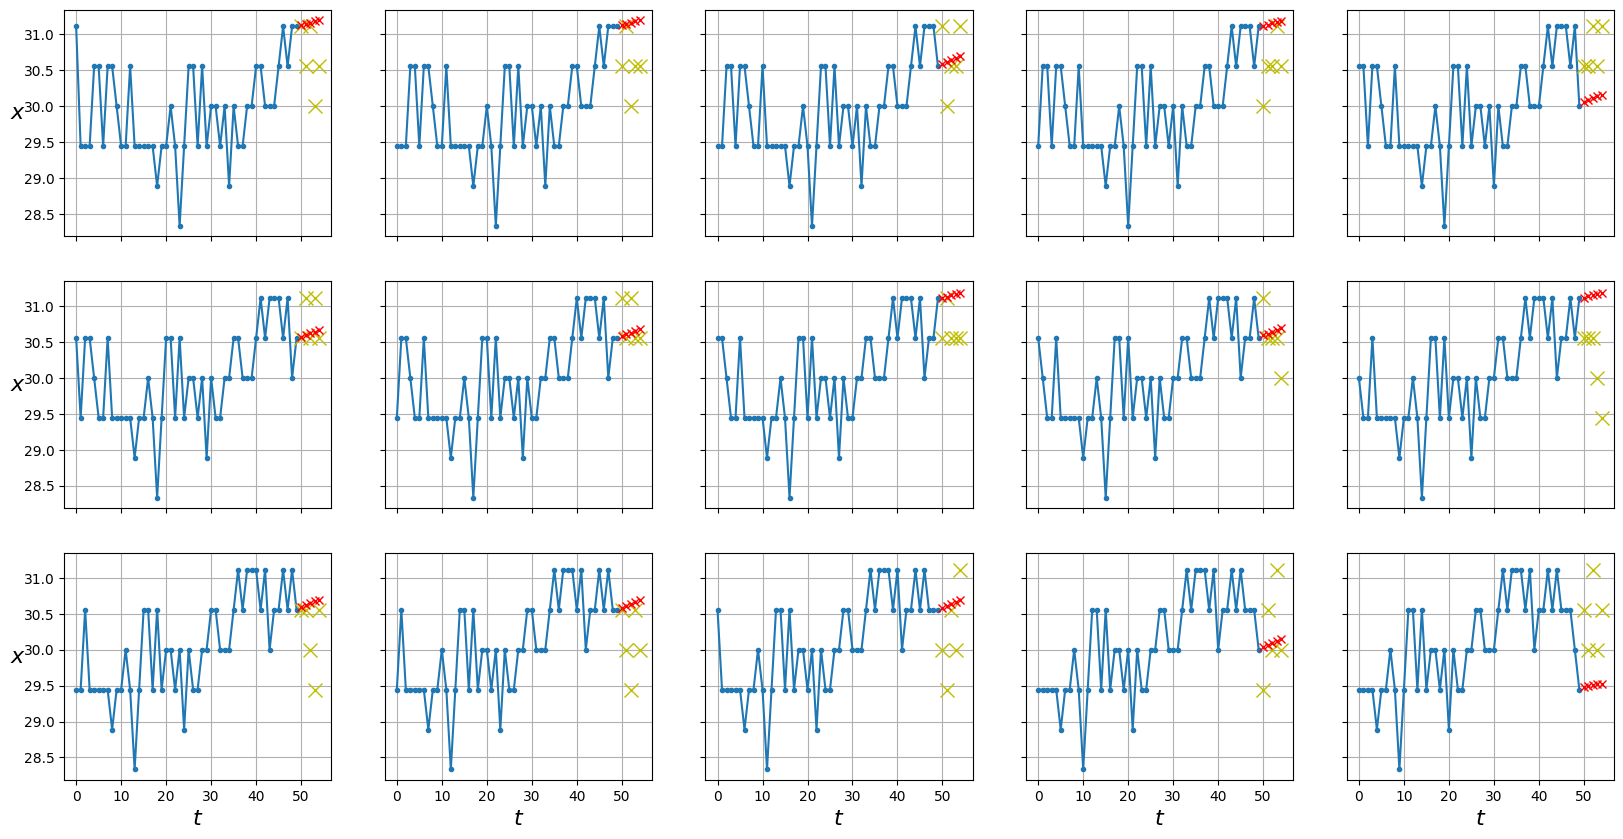

3.3540523052215576

In [219]:

x = x_test
for step_ahead in range(5):
    inputs = torch.from_numpy(x[:, step_ahead:]).unsqueeze(0)
    y_pred_one = predict(rnn, inputs).cpu().numpy()
    x = np.concatenate([x, y_pred_one[:, np.newaxis]], axis=1)

y_pred = x[:, n_steps:, -1]
print(y_pred.shape)
plot_series(x_test, y_test, y_pred)
mean_squared_error(y_test, y_pred)

In [220]:
n_steps = 50
x_train = series[:7000, :n_steps]
x_valid = series[7000:9000, :n_steps]
x_test = series[9000:, :n_steps]
y = np.empty((10000, n_steps, 5), dtype=np.float32)
for step_ahead in range(1, 5 + 1):
    y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
y_train = y[:7000]
y_valid = y[7000:9000]
y_test = y[9000:]

dataset = {
    'train': TimeSeriesDataset(x_train, y_train),
    'eval': TimeSeriesDataset(x_valid, y_valid),
    'test': TimeSeriesDataset(x_test, y_test, train=False)
}
dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [221]:
class DeepRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepRNN, self).__init__()
        self.rnn = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, h = self.rnn(x)
        x_reshaped = x.contiguous().view(-1, x.shape[-1])
        y = self.linear(x_reshaped)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))
        return y


In [222]:
def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs + 1))
    for _ in bar:
        model.train()
        train_loss = []
        train_loss2 = []
        for batch in dataloader['train']:
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_loss2.append((y[:,-1]-y_pred[:,-1]).pow(2).mean().item())
        model.eval()
        eval_loss = []
        eval_loss2 = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                x, y = batch
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                loss = criterion(y_pred, y)
                eval_loss.append(loss.item())
                eval_loss2.append((y[:,-1]-y_pred[:,-1]).pow(2).mean().item())
                bar.set_description(f"loss: {np.mean(train_loss):.5f} eval_loss: {np.mean(eval_loss):.5f}")
        bar.set_description(f"loss {np.mean(train_loss):.5f} loss_last_stp {np.mean(train_loss2):.5f} eval_loss {np.mean(eval_loss):.5f} eval_loss_last_stp {np.mean(eval_loss2):.5f}")

rnn = DeepRNN(input_size=1, hidden_size=20, output_size=5)
fit(rnn, dataloader,epochs=100)


loss 5.40492 loss_last_stp 5.35976 eval_loss 4.05965 eval_loss_last_stp 3.91843: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s]      


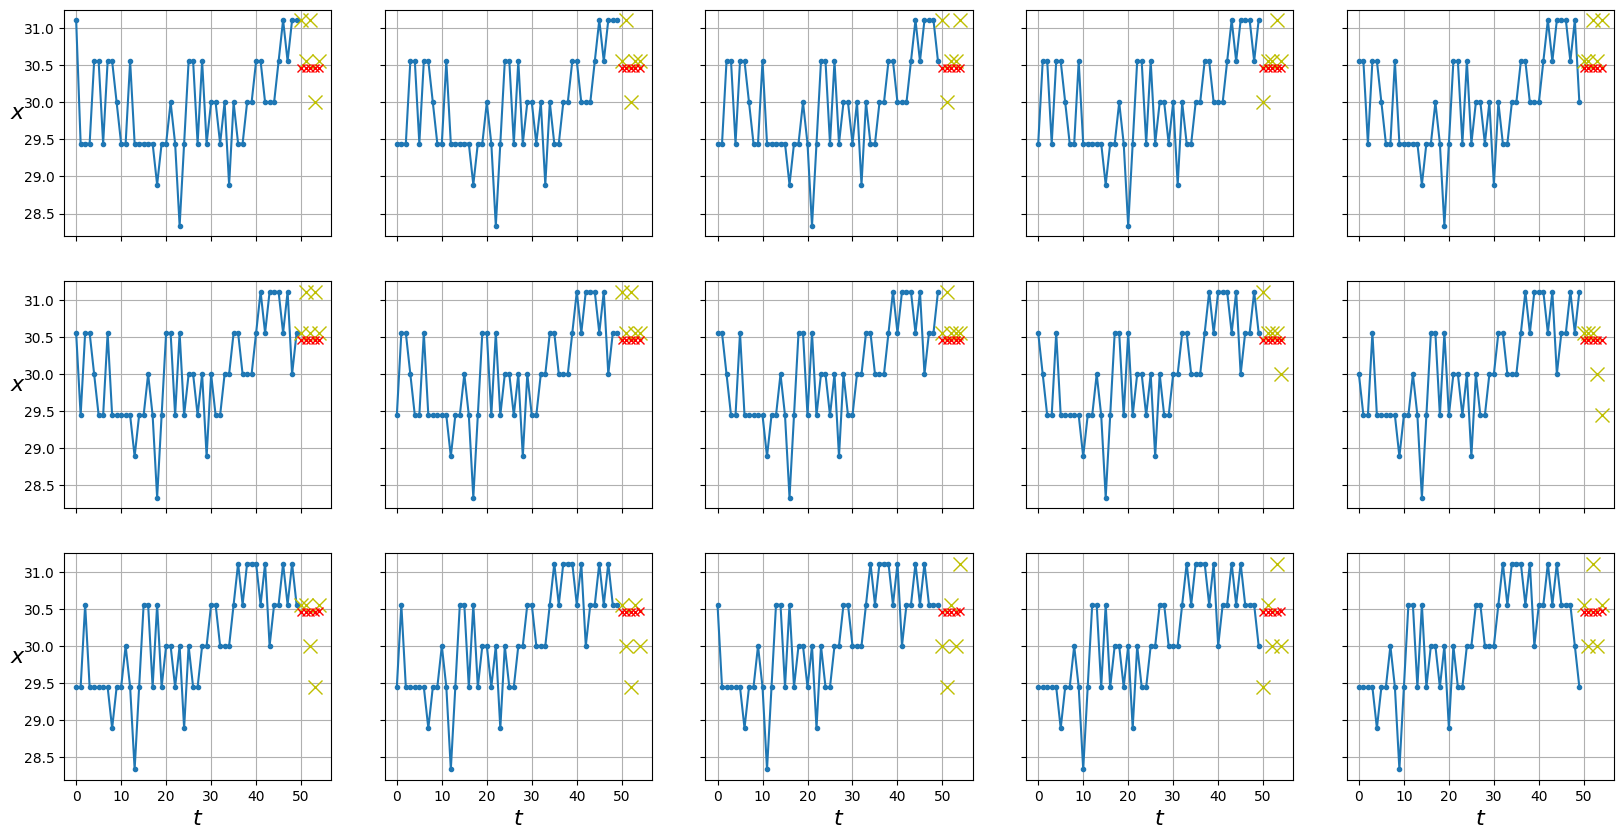

3.4966232776641846

In [223]:
y_pred= predict(rnn, dataloader['test'])
plot_series(x_test, y_test[:,-1], y_pred[:,-1].cpu().numpy())
mean_squared_error(y_test[:,-1], y_pred[:,-1].cpu())